# 비즈니스 관점_모델평가



## 1.환경준비

### (1) 라이브러리 로딩

In [1]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from keras.backend import clear_session
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

### (2) 필요 함수들 생성

#### ① reconstruction error plot

> * input과 output의 차이(mse)를 계산하고
* 시각화 합니다.



In [2]:
def recon_err_plot(x, x_pred, y, threshold=0):
    # treshold : 우리가 지정해줘야 함.(어떻게?)

    # 재구성 오차 계산
    mse = np.mean(np.power(x - x_pred, 2), axis=1)
    error_df = pd.DataFrame({'recon_err': mse, 'y': y})
    error_df = error_df.reset_index()

    # 재구성 오차 그래프
    groups = error_df.groupby('y')
    fig, ax = plt.subplots()
    for name, group in groups:
        ax.plot(group.index, group.recon_err, marker='o', ms=3.5, linestyle='',
                label= "Abnormal" if name == 1 else "Normal")
    ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
    ax.legend()
    plt.title("Reconstruction error for each data point")
    plt.ylabel("Reconstruction error")
    plt.xlabel("Data point index")
    plt.show()

    return error_df

#### ② precision, recall, f1 curve

> * sklearn에서는 precision, recall curve만 제공됩니다.
* 그래서, f1 curve도 추가해서 구하고, plot을 그립니다.



In [3]:
def prec_rec_f1_curve(y, score, pos = 1) :
    precision, recall, thresholds  = precision_recall_curve(y, score, pos_label=1)
    f1 = 2 / (1/precision + 1/recall)

    plt.figure(figsize = (8, 6))
    plt.plot(thresholds, np.delete(precision, -1), label = 'precision')
    plt.plot(thresholds, np.delete(recall, -1), label = 'recall')
    plt.plot(thresholds, np.delete(f1, -1), label = 'f1')
    plt.xlabel('Anomaly Score')
    plt.legend()
    plt.grid()
    plt.show()

    return precision, recall, f1, thresholds

#### ③ threshold로 잘랐을 때, 분류 평가 함수


In [4]:
from sklearn.metrics import confusion_matrix, classification_report

def classification_report2(y, pred, thresholds):
    pred_temp = np.where(pred > thresholds , 1, 0)
    cm = confusion_matrix(y, pred_temp)
    print('< confusion matrix >\n')
    print(cm)
    print('\n' + '='*60 + '\n')

    print('< classification_report >\n')
    print(classification_report(y, pred_temp))

    return cm

#### ④ DL 학습곡선 그리기


In [5]:
def plot_learning_curve(history) :
    plt.figure(figsize = (10,6))
    plt.plot(history['loss'], label='Train', marker = '.')
    plt.plot(history['val_loss'], label='Validation', marker = '.')

    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.grid()
    plt.show()

### (3) 데이터셋 불러오기

![](https://keralakaumudi.com/web-news/en/2020/04/NMAN0141956/image/paper-mill.1.582102.jpg)

In [6]:
# 공정 데이터 불러오기
path = "https://raw.githubusercontent.com/DA4BAM/dataset/master/processminer3.csv"
data = pd.read_csv(path)
data.head()

,y,time,x1,x2,x3,x4,x5,x6,x7,x8,...,x51,x52,x53,x54,x55,x56,x57,x58,x59,x60
0,0.0,1999-05-01 00:00:00,0.376665,-4.596435,-4.095756,13.497687,-0.118830,-20.669883,0.000732,-0.061114,...,29.984624,10.091721,0.053279,-4.936434,-24.590146,18.515436,3.473400,0.033444,0.953219,0.006076
1,0.0,1999-05-01 00:02:00,0.475720,-4.542502,-4.018359,16.230659,-0.128733,-18.758079,0.000732,-0.061114,...,29.984624,10.095871,0.062801,-4.937179,-32.413266,22.760065,2.682933,0.033536,1.090502,0.006083
2,0.0,1999-05-01 00:04:00,0.363848,-4.681394,-4.353147,14.127997,-0.138636,-17.836632,0.010803,-0.061114,...,29.984624,10.100265,0.072322,-4.937924,-34.183774,27.004663,3.537487,0.033629,1.840540,0.006090
3,0.0,1999-05-01 00:06:00,0.301590,-4.758934,-4.023612,13.161566,-0.148142,-18.517601,0.002075,-0.061114,...,29.984624,10.104660,0.081600,-4.938669,-35.954281,21.672449,3.986095,0.033721,2.554880,0.006097
4,0.0,1999-05-01 00:08:00,0.265578,-4.749928,-4.333150,15.267340,-0.155314,-17.505913,0.000732,-0.061114,...,29.984624,10.109054,0.091121,-4.939414,-37.724789,21.907251,3.601573,0.033777,1.410494,0.006105


In [8]:
data.shape

(12143, 61)

* y의 비율

In [7]:
data['y'].value_counts(normalize = True)


0.0    0.986412
1.0    0.013588
Name: y, dtype: float64

## 2.데이터 준비

### (1) 불필요한 변수 제거

In [9]:
data.drop('time', axis=1, inplace=True)

### (2) 데이터 분할

* x, y 분할

In [10]:
target = 'y'
x = data.drop(target, axis = 1)
y = data.loc[:, target]

In [11]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = 6000, random_state = 20)

### (3) 스케일링


In [12]:
scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_val = scaler.transform(x_val)

### (4) 학습용 Normal Data

In [13]:
x_train0 = x_train[y_train == 0]

## 3.모델링 실습
* 원하는 구조로 모델을 설계하고 학습해 봅시다.
* 참조 구성 : 아래와 같이 구성해도 좋습니다.
    * Input(59)
    * Dense(16)
    * Dense(8)
    * Dense(16)
    * Dense(59)


In [14]:
x_train0.shape

(6067, 59)

### (1) Auto Encoder
* 모델 설계

In [15]:
input_dim = x_train0.shape[1] #num of columns

clear_session()
model = Sequential([Dense(16, input_shape = (input_dim,), activation = 'relu'),
                          Dense(8, activation="relu"),
                          Dense(16, activation="relu"),
                          Dense(input_dim, activation='relu')])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                960       
                                                                 
 dense_1 (Dense)             (None, 8)                 136       
                                                                 
 dense_2 (Dense)             (None, 16)                144       
                                                                 
 dense_3 (Dense)             (None, 59)                1003      
                                                                 
Total params: 2,243
Trainable params: 2,243
Non-trainable params: 0
_________________________________________________________________


* 학습

In [16]:
model.compile(optimizer= Adam(learning_rate = 0.01), loss='mse')

history = model.fit(x = x_train0, y = x_train0, epochs=50, batch_size=64,
                          validation_split = .2).history

Epoch 1/50
76/76 [==============================] - 1s 5ms/step - loss: 0.0904 - val_loss: 0.0649
Epoch 2/50
76/76 [==============================] - 0s 3ms/step - loss: 0.0555 - val_loss: 0.0511
Epoch 3/50
76/76 [==============================] - 0s 2ms/step - loss: 0.0491 - val_loss: 0.0493
Epoch 4/50
76/76 [==============================] - 0s 3ms/step - loss: 0.0478 - val_loss: 0.0480
Epoch 5/50
76/76 [==============================] - 0s 3ms/step - loss: 0.0468 - val_loss: 0.0473
Epoch 6/50
76/76 [==============================] - 0s 3ms/step - loss: 0.0423 - val_loss: 0.0397
Epoch 7/50
76/76 [==============================] - 0s 3ms/step - loss: 0.0392 - val_loss: 0.0393
Epoch 8/50
76/76 [==============================] - 0s 3ms/step - loss: 0.0386 - val_loss: 0.0381
Epoch 9/50
76/76 [==============================] - 0s 2ms/step - loss: 0.0376 - val_loss: 0.0374
Epoch 10/50
76/76 [==============================] - 0s 3ms/step - loss: 0.0371 - val_loss: 0.0371
Epoch 11/50
76/76 [

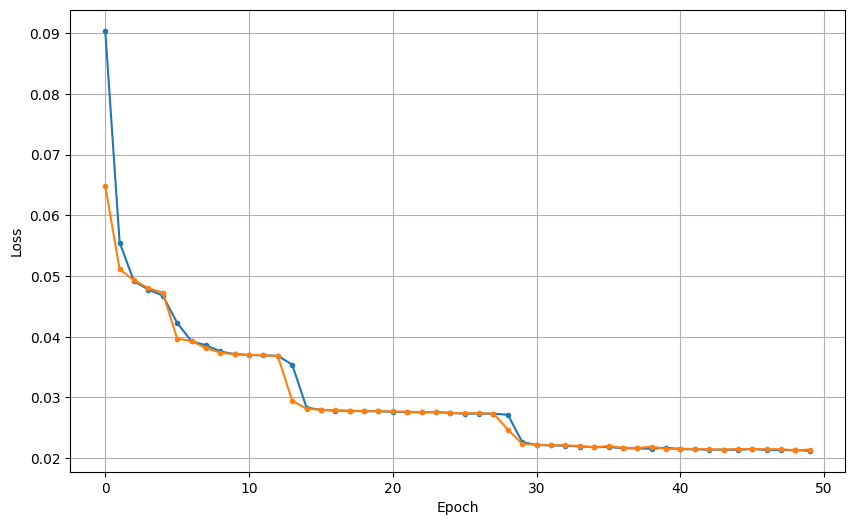

In [17]:
plot_learning_curve(history)

### (2) 분류에 대한 평가

#### 1) 예측

In [18]:
pred = model.predict(x_val)

188/188 [==============================] - 1s 2ms/step


#### 2) 재구성 오차 계산

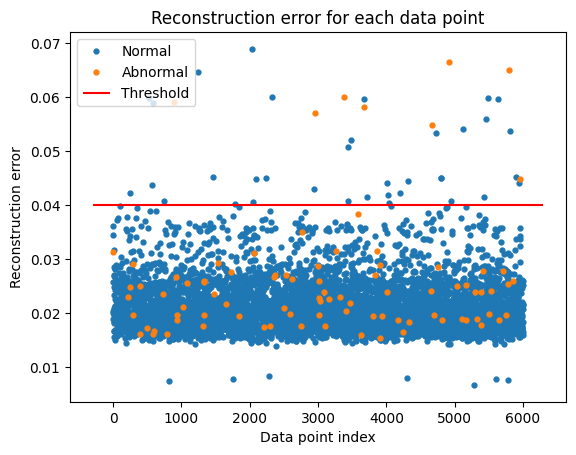

In [19]:
result = recon_err_plot(x_val, pred, y_val, 0.04)

#### 3) cut-off 찾기
* threshold 값을 조절하면서, precision, recall, f1 score 그래프를 그려 봅시다.

<ipython-input-3-0b309618100c>:3: RuntimeWarning: divide by zero encountered in true_divide
  f1 = 2 / (1/precision + 1/recall)


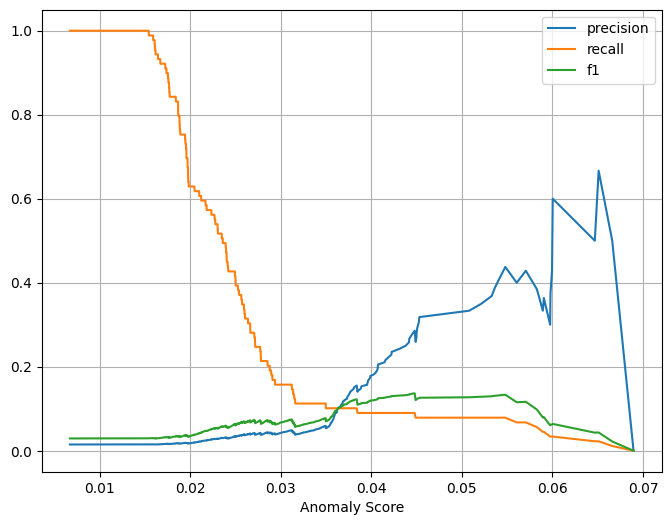

In [20]:
_, _, f1, thresholds = prec_rec_f1_curve(result['y'], result['recon_err'])

* f1 score를 가장 높이는 threshold 값

In [21]:
thres_f1_max = thresholds[np.argmax(f1)]
thres_f1_max

0.044785844885360825

#### 4) 잘라서 평가하기

In [23]:
cm = classification_report2(result['y'], result['recon_err'], thres_f1_max)

< confusion matrix >

[[5891   20]
 [  82    7]]


< classification_report >

              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99      5911
         1.0       0.26      0.08      0.12        89

    accuracy                           0.98      6000
   macro avg       0.62      0.54      0.56      6000
weighted avg       0.98      0.98      0.98      6000



## 4.비즈니스 관점에서의 모델 평가

> * 한 롤로 종이를 말다가 찢어지는 사고가 하루에 한번 정도 발생.
* 이때마다 공정 중단 및 수율 저하 등, 평균적으로 100백만원의 손실이 발생
* 이를 사전에 감지하는 것은 굉장히 어려움. 이런 사고를 5%만 감소시키더라도 회사 입장에서는 상당한 비용 절감효과 예상.
* 장애가 예상된다면, 속도를 줄여 장애를 예방할 수 있다. 단, 속도를 줄이면 생산성이 저하되므로, 1회당 평균 3만원의 손실이 발생됩니다.


### 1) 비즈니스 기대가치 매트릭스

In [24]:
bv = np.array([[0,3],[100,3]])
bv

array([[  0,   3],
       [100,   3]])

### 2) cost 계산

* 예측값에 대한 cost 계산

In [25]:
np.sum(cm * bv)

8281

### 3) threshold 값을 조정하면서 cost를 계산해 봅시다.

#### ① 비교대상(Base Cost) 계산

* 1) 예방활동을 하지 않고, 장애 발생에 대한 조치 비용 계산 ==> 계산가능
* 2) 현재 수행중인 예방활동 비용 + 장애발생 비용 계산 ==> 이 부분은 현재 모르므로 여기서는 다루지 않음

In [26]:
base_cost = result['y'].sum() * 100
base_cost

8900.0

#### ② threshold 값 조정하며 Cost 계산

In [27]:
cost = []
for v in thresholds :
    y_pred = np.where(result['recon_err']>= v, 1, 0)
    cm = confusion_matrix(result['y'], y_pred)
    cost.append(np.sum(cm * bv))

cost = np.array(cost)

### 4) 그래프를 그려 봅시다.

In [28]:
thresholds[np.argmin(cost)]

0.026621749223773167

Anomaly Score : 0.02662,  Min Cost : 8171


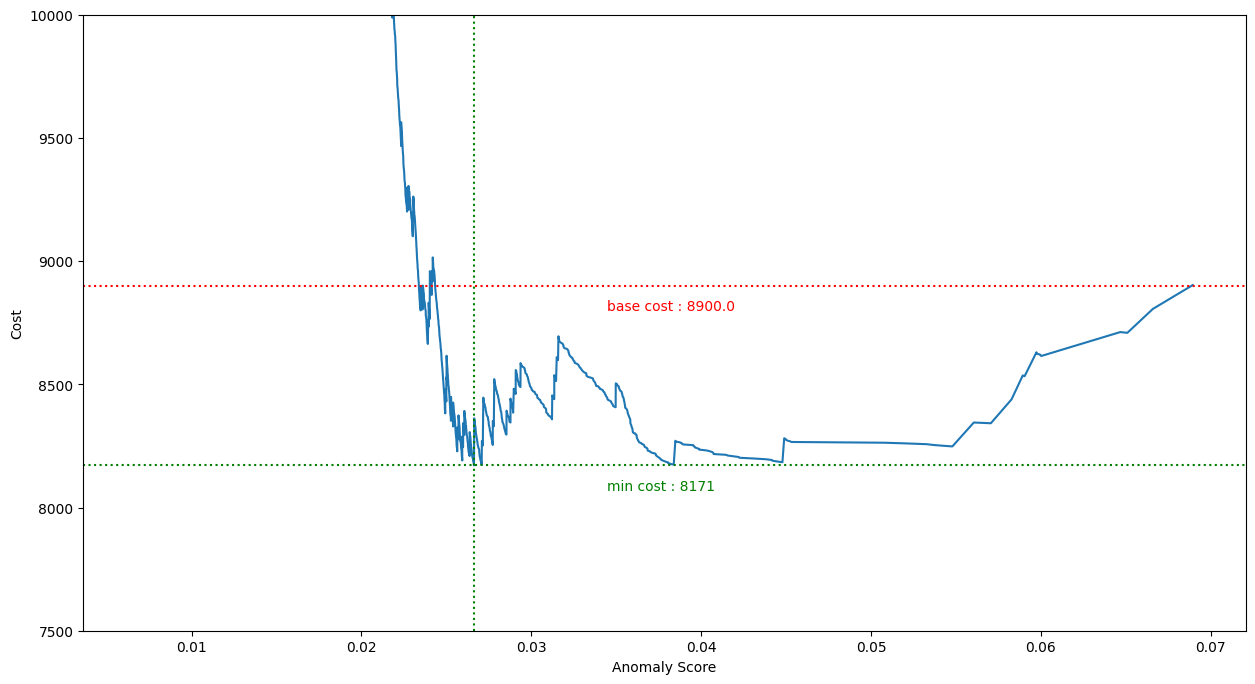

In [29]:
min_tres = round(thresholds[np.argmin(cost)],5)

print(f'Anomaly Score : {min_tres},  Min Cost : {min(cost)}' )
plt.figure(figsize = (15, 8))
plt.plot(thresholds, cost)

plt.axhline(base_cost, color = 'r', linestyle = ":")
plt.axhline(min(cost), color = 'g', linestyle = ":")
plt.axvline(min_tres, color = 'g', linestyle = ":")

plt.text(max(thresholds)/2, base_cost-100, f"base cost : {base_cost}", color = 'r')
plt.text(max(thresholds)/2, min(cost)-100, f"min cost : {min(cost)}", color = 'g')

plt.ylim(7500, 10000)
plt.xlabel("Anomaly Score")
plt.ylabel("Cost")
plt.show()